In [20]:
from __future__ import print_function
%matplotlib inline 

# Sliders Example 

This is an example of interactive iPython workbook that uses widgets to meaningfully interact with visualization. 

In [21]:
# Imports 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from ipywidgets import interact, interactive, fixed

import ipywidgets as widgets

In [3]:
# Data Loading 
columns = OrderedDict([
    ("DAY", "the day of data collection"),
    ("Q-E", "input flow to plant"),
    ("ZN-E", "input Zinc to plant"),
    ("PH-E", "input pH to plant"),
    ("DBO-E", "input Biological demand of oxygen to plant"),
    ("DQO-E", "input chemical demand of oxygen to plant"),
    ("SS-E", "input suspended solids to plant"),
    ("SSV-E", "input volatile supended solids to plant"),
    ("SED-E", "input sediments to plant"),
    ("COND-E", "input conductivity to plant"),
    ("PH-P", "input pH to primary settler"),
    ("DBO-P", "input Biological demand of oxygen to primary settler"),
    ("SS-P", "input suspended solids to primary settler"),
    ("SSV-P", "input volatile supended solids to primary settler"),
    ("SED-P", "input sediments to primary settler"),
    ("COND-P", "input conductivity to primary settler"),
    ("PH-D", "input pH to secondary settler"),
    ("DBO-D", "input Biological demand of oxygen to secondary settler"),
    ("DQO-D", "input chemical demand of oxygen to secondary settler"),
    ("SS-D", "input suspended solids to secondary settler"),
    ("SSV-D", "input volatile supended solids to secondary settler"),
    ("SED-D", "input sediments to secondary settler"),
    ("COND-S", "input conductivity to secondary settler"),
    ("PH-S", "output pH"),
    ("DBO-S", "output Biological demand of oxygen"),
    ("DQO-S", "output chemical demand of oxygen"),
    ("SS-S", "output suspended solids"),
    ("SSV-S", "output volatile supended solids"),
    ("SED-S", "output sediments"),
    ("COND-", "output conductivity"),
    ("RD-DB-P", "performance input Biological demand of oxygen in primary settler"),
    ("RD-SSP", "performance input suspended solids to primary settler"),
    ("RD-SE-P", "performance input sediments to primary settler"),
    ("RD-DB-S", "performance input Biological demand of oxygen to secondary settler"),
    ("RD-DQ-S", "performance input chemical demand of oxygen to secondary settler"),
    ("RD-DB-G", "global performance input Biological demand of oxygen"),
    ("RD-DQ-G", "global performance input chemical demand of oxygen"),
    ("RD-SSG", "global performance input suspended solids"),
    ("RD-SED-G", "global performance input sediments"),
])

data = pd.read_csv("data/water-treatment.data", names=columns.keys())
data = data.replace('?', np.nan)

In [4]:
# Capture only the numeric columns in the data set. 
numeric_columns = columns.keys()
numeric_columns.remove("DAY")
data = data[numeric_columns].apply(pd.to_numeric)

## 2D Rank Features 

In [40]:
def apply_column_pairs(func):
    """
    Applies a function to a pair of columns and returns a new 
    dataframe that contains the result of the function as a matrix
    of each pair of columns. 
    """
    
    def inner(df):
        cols = pd.DataFrame([
            [
                func(df[acol], df[bcol]) for bcol in df.columns
            ] for acol in df.columns
        ])

        cols.columns = df.columns
        cols.index = df.columns 
        return cols

    return inner 


@apply_column_pairs
def least_square_error(cola, colb):
    """
    Computes the Root Mean Squared Error of a linear regression 
    between two columns of data. 
    """
    x = cola.fillna(np.nanmean(cola))
    y = colb.fillna(np.nanmean(colb))
    
    m, b = np.polyfit(x, y, 1)
    yh  = (x * m) + b 
    return ((y-yh) ** 2).mean()

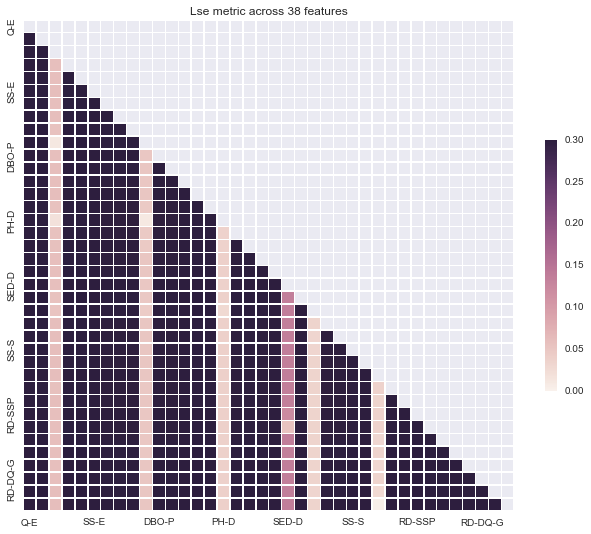

In [41]:
labeled_metrics = {
    'Pearson': 'pearson', 
    'Kendall Tao': 'kendall', 
    'Spearman': 'spearman', 
    'Pairwise Covariance': 'covariance',
    'Least Squares Error': 'lse', 
}

@interact(metric=labeled_metrics, data=fixed(data))
def rank2d(data, metric='pearson'):
    """
    Creates a visualization of pairwise ranking by column in the data. 
    """
    
    # The different rank by 2d metrics. 
    metrics = {
        "pearson": lambda df: df.corr('pearson'), 
        "kendall": lambda df: df.corr('kendall'), 
        "spearman": lambda df: df.corr('spearman'), 
        "covariance": lambda df: df.cov(), 
        "lse": least_square_error,
    }
    
    # Quick check to make sure a valid metric is passed in. 
    if metric not in metrics:
        raise ValueError(
            "'{}' not a valid metric, specify one of {}".format(
                metric, ", ".join(metrics.keys())
            )
        )
    
    
    # Compute the correlation matrix
    corr = metrics[metric](data)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    ax.set_title("{} metric across {} features".format(metric.title(), len(data.columns)))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, vmax=.3,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

## Alpha Visualization and Regression 

In [19]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from download import download_all 

## The path to the test data sets
FIXTURES  = os.path.join(os.getcwd(), "data")

## Dataset loading mechanisms
datasets = {
    "credit": os.path.join(FIXTURES, "credit", "credit.csv"),
    "concrete": os.path.join(FIXTURES, "concrete", "concrete.csv"),
    "occupancy": os.path.join(FIXTURES, "occupancy", "occupancy.csv"),
}


def load_data(name, download=True):
    """
    Loads and wrangles the passed in dataset by name.
    If download is specified, this method will download any missing files. 
    """
    
    # Get the path from the datasets 
    path = datasets[name]
    
    # Check if the data exists, otherwise download or raise 
    if not os.path.exists(path):
        if download:
            download_all() 
        else:
            raise ValueError((
                "'{}' dataset has not been downloaded, "
                "use the download.py module to fetch datasets"
            ).format(name))
        
    
    # Return the data frame
    return pd.read_csv(path)

In [58]:
# Load the data
df = load_data('concrete')
feature_names = ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age']
target_name = 'strength'

# Get the X and y data from the DataFrame 
X = df[feature_names].as_matrix()
y = df[target_name].as_matrix() 

# Set the alphas 
alphas = np.logspace(-10, 0, 400)

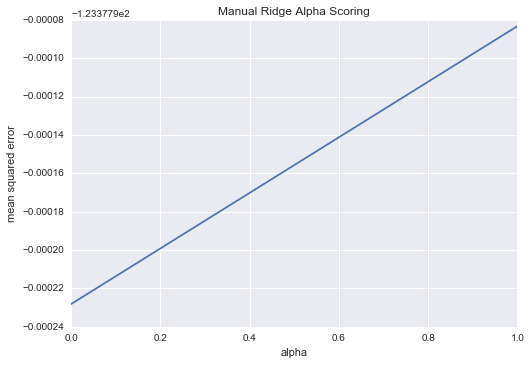

In [86]:
from sklearn.linear_model import Ridge
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

errors = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    score = cross_val_score(model, X, y, cv=12, scoring='mean_squared_error')
    errors.append(score.mean())

plt.plot(alphas, errors, label='ridge')
plt.xlabel('alpha')
plt.ylabel('mean squared error')
plt.title("Manual Ridge Alpha Scoring")
plt.show()

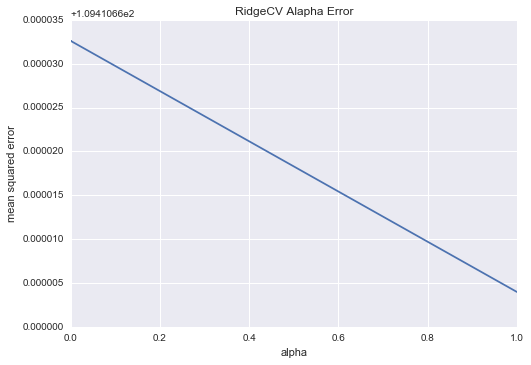

In [66]:
from sklearn.linear_model import RidgeCV 

# Must pass store_cv_values=True in order to store the MSE of the alphas. 
ridge = RidgeCV(alphas=alphas, store_cv_values=True)
ridge.fit(X, y)

# cv_values_ : array, shape = [n_samples, n_alphas] or shape = [n_samples, n_targets, n_alphas], optional
# Cross-validation values for each alpha (if store_cv_values=True and cv=None). 
# After fit() has been called, this attribute will contain the mean squared errors (by default) or the 
# values of the {loss,score}_func function (if provided in the constructor).
ridge.cv_values_.mean(0)

g = plt.plot(ridge.alphas, ridge.cv_values_.mean(0), label="ridge")
plt.xlabel("alpha")
plt.ylabel("mean squared error")
plt.title("RidgeCV Alapha Error")
plt.show()

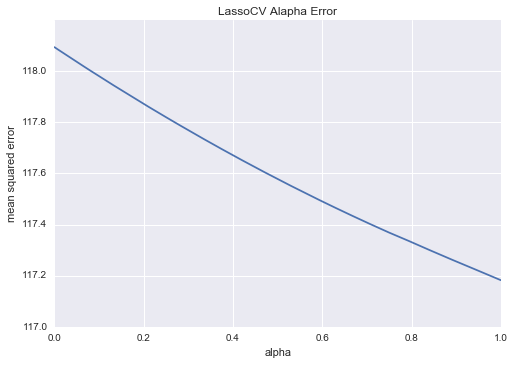

In [67]:
from sklearn.linear_model import LassoCV 

lasso = LassoCV(alphas=alphas)
lasso.fit(X, y)

# mse_path_ : array, shape (n_l1_ratio, n_alpha, n_folds)
# Mean square error for the test set on each fold, varying l1_ratio and alpha.

g = plt.plot(lasso.alphas_, lasso.mse_path_.mean(1), label="lasso")
plt.xlabel("alpha")
plt.ylabel("mean squared error")
plt.title("LassoCV Alapha Error")
plt.show()

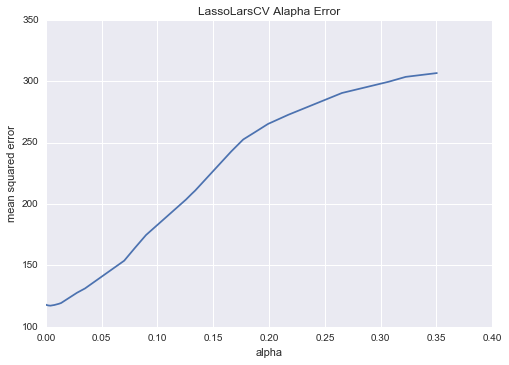

In [74]:
from sklearn.linear_model import LassoLarsCV 

larslasso = LassoLarsCV()
larslasso.fit(X, y)

# mse_path_ : array, shape (n_l1_ratio, n_alpha, n_folds)
# Mean square error for the test set on each fold, varying l1_ratio and alpha.

g = plt.plot(larslasso.cv_alphas_, larslasso.cv_mse_path_.mean(1), label="lasso lars")
plt.xlabel("alpha")
plt.ylabel("mean squared error")
plt.title("LassoLarsCV Alapha Error")
plt.show()

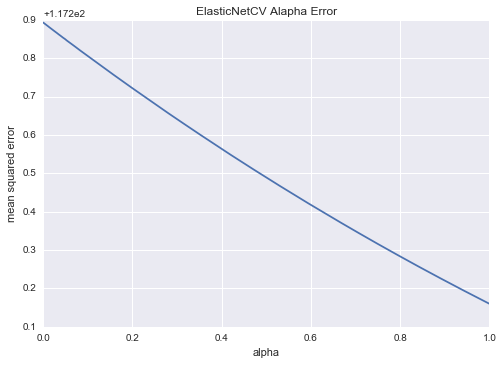

In [68]:
from sklearn.linear_model import ElasticNetCV 

enet = ElasticNetCV(alphas=alphas)
enet.fit(X, y)

g = plt.plot(enet.alphas_, enet.mse_path_.mean(1), label="elasticnet")
plt.xlabel("alpha")
plt.ylabel("mean squared error")
plt.title("ElasticNetCV Alapha Error")
plt.show()

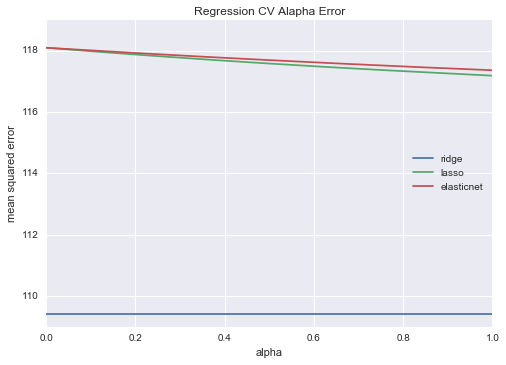

In [76]:
# Plot all 
plt.plot(ridge.alphas, ridge.cv_values_.mean(0), label="ridge")
plt.plot(lasso.alphas_, lasso.mse_path_.mean(1), label="lasso")
# plt.plot(larslasso.cv_alphas_, larslasso.cv_mse_path_.mean(1), label="lasso lars")
plt.plot(enet.alphas_, enet.mse_path_.mean(1), label="elasticnet")
plt.xlabel("alpha")
plt.ylabel("mean squared error")
plt.title("Regression CV Alapha Error")
plt.legend(loc='best')
plt.show()